In [1]:
import os
import glob
import natsort
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Some signal averaging for Mitchell

## Load files first
The example data files are all placed in `data` folder, write a function to create a list of files in memory:

In [2]:
def get_files(pattern):
    """
    Extracts file in alphanumerical order that match the provided pattern
    """
    if isinstance(pattern, list):
        pattern = os.path.join(*pattern)
        
    files = natsort.natsorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError('Pattern could not detect file(s)')
        
    return files

### Inputs Cell:

Place your path to input and output directories in `" "`.

In [3]:
data_dir = 'data'    # Replace data with relative path to new folder like I mentioned before
output_dir = 'outputs'    # same replacement for outputs

Load as `DataFrames`, mag or magenta should work now.

In [4]:
import re

data_files = get_files(data_dir + '/*.csv')
print('There are {} data csv files'.format(len(data_files)))

# split into cyan, yellow, magenta
cyan_data = [val for val in data_files if re.search(r'cyan\.csv', val)]
yellow_data = [val for val in data_files if re.search(r'yellow\.csv', val)]
magenta_data = [val for val in data_files if re.search(r'(mag|magenta)\.csv', val)]

# sanity check to make sure they are the same number of files
assert len(cyan_data)==len(yellow_data)==len(magenta_data)

There are 168 data csv files


## Create channel specific dataframes

In [5]:
df_cyan = pd.concat((pd.read_csv(f, usecols=['Value']) for f in cyan_data), axis = 1).fillna(0)
df_yellow = pd.concat((pd.read_csv(f, usecols=['Value']) for f in yellow_data), axis = 1).fillna(0)
df_magenta = pd.concat((pd.read_csv(f, usecols=['Value']) for f in magenta_data), axis = 1).fillna(0)

df_cyan.columns = np.arange(df_cyan.shape[1])
df_yellow.columns = np.arange(df_yellow.shape[1])
df_magenta.columns = np.arange(df_magenta.shape[1])
# show example:
df_magenta.head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,289.863,792.889,302.869,371.121,140.696,334.924,299.704,353.357,631.267,466.130,...,96.078,276.816,266.222,219.779,754.120,488.254,669.577,73.255,446.116,384.237
1,291.704,587.853,215.438,350.101,130.079,184.644,159.297,384.376,626.304,339.646,...,103.717,344.160,259.550,140.388,689.636,573.782,578.182,158.501,508.400,394.645
2,394.281,390.960,146.048,532.695,140.317,186.202,201.759,314.848,573.621,459.111,...,144.980,343.142,235.141,248.528,600.701,496.957,562.589,161.242,428.764,364.166
3,411.526,424.690,195.087,560.279,148.483,172.712,205.261,335.292,389.180,421.931,...,76.867,217.119,228.931,318.952,513.784,358.028,628.985,64.746,377.364,376.755
4,352.564,461.656,204.790,497.579,159.929,235.265,268.972,387.189,399.120,437.170,...,98.427,196.381,260.193,439.384,478.446,289.196,564.748,67.193,396.536,302.703


Now we have 3 Nx56 dataframes that are actually usable ... not stupid `.csv` files

Now we write a function to realign the data:

In [6]:
def find_middle(in_column):
    """
    Find the middle index of input data column/array
    """
    middle = float(len(in_column))/2
    # if even, pick the first value, if odd, keep middle
    if middle % 2 != 0:
        # odd
        return int(np.floor(middle))
    else:
        return int(middle)
    

def realign_data(in_data, align = "max"):
    """
    Center data around maximum or center of shortest column, pad with 0's 
    Args:
        in_data: array of input data
        align (str): "max" or "center", max will provide shifts to align maximum of input  data, whereas "center" will shift to middle index.
    
    Returns:
        d - new dataframe with realigned data
        shifts - how each entry was shifted
    """
    x, y = in_data.shape
    d = pd.DataFrame(0, index=np.arange(x), columns = np.arange(y))
    shifts = np.zeros(y)
    
    # Find longest length sample and find it's peak/midpoint
    ind_longest = np.argmin((in_data == 0).astype(int).sum(axis=0).values)
    peak_longest = np.argmax(in_data.loc[:, ind_longest].values)
    mid_longest = find_middle(in_data.index[in_data[ind_longest]!=0].values)
    
    # arrange the rest of the data's peaks into the new dataframe lining up to longest peak or longest midpoint
    for column in in_data:
        if align == "max":
            peak = np.argmax(in_data[column].values)
            pdiff = peak_longest - peak
            d[column] = in_data[column].shift(periods=pdiff, fill_value=0)
            # check shifted max location of input is same as reference peak
            assert np.argmax(d[column]) == peak_longest
            shifts[column] = pdiff
        elif align == "center":
            mid = find_middle(in_data.index[in_data[column]!=0].values)
            pdiff = mid_longest - mid
            d[column] = in_data[column].shift(periods=pdiff, fill_value=0)
            assert find_middle(d[column].values) == mid_longest
            shifts[column] = pdiff
            
    return d, shifts

def shift_data(in_data, shifts):
    """
    Shift dataframe columns based on input reference shifts
    
    Returns:
        d - new shifted dataframe
    """
    x, y = in_data.shape
    d = pd.DataFrame(0, index=np.arange(x), columns = np.arange(y))
    ind_shifts = shifts.astype(int)
    for column in in_data:
        d[column] = in_data[column].shift(periods=ind_shifts[column], fill_value=0)
        
    return d

### Visualize the averaged aligned curve:

For the function `realign_data`, edit the second argument `align` to either `max` or `center` based on your needs.

In [7]:
from sklearn.preprocessing import minmax_scale

cyan_aligned, shifts = realign_data(df_cyan, align = "max")    # change "max" or "center" based on your needs
yellow_aligned = shift_data(df_yellow, shifts)
magenta_aligned = shift_data(df_magenta, shifts)

ave_cyan = np.zeros(cyan_aligned.shape[0])
ave_yellow = np.zeros(yellow_aligned.shape[0])
ave_magenta = np.zeros(magenta_aligned.shape[0])

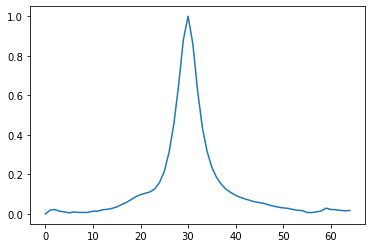

In [8]:
for index, row in cyan_aligned.iterrows():
    #vec = cyan_aligned.loc[index,:].values
    val = row[row != 0]
    ave_cyan[index] = np.mean(val)

# assign both normalized and unnormalized dataframes to outputs
cyan_normalized = pd.DataFrame(0, index=cyan_aligned.index, columns = cyan_aligned.columns)
for column, vals in cyan_aligned.iteritems():
    event_ind = cyan_aligned.index[cyan_aligned[column]!=0].tolist()
    cyan_normalized.loc[event_ind, column] = minmax_scale(cyan_aligned.loc[event_ind,column].values)

# visualize the average curve
plt.plot(minmax_scale(ave_cyan))

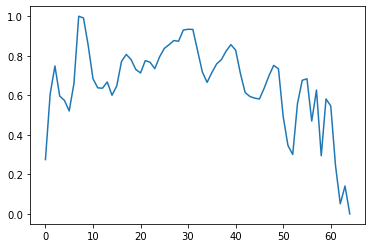

In [9]:
for index, row in yellow_aligned.iterrows():
    val = row[row!=0]
    ave_yellow[index] = np.mean(val)

# assign both normalized and unnormalized dataframes to outputs
yellow_normalized = pd.DataFrame(0, index=yellow_aligned.index, columns = yellow_aligned.columns)
for column, vals in yellow_aligned.iteritems():
    event_ind = yellow_aligned.index[yellow_aligned[column]!=0].tolist()
    yellow_normalized.loc[event_ind, column] = minmax_scale(yellow_aligned.loc[event_ind,column].values)
    
plt.plot(minmax_scale(ave_yellow))

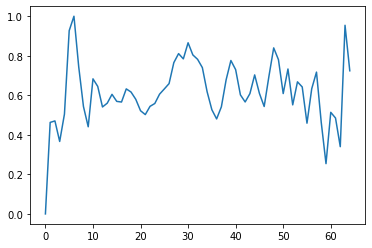

In [10]:
for index, row in magenta_aligned.iterrows():
    val = row[row!=0]
    ave_magenta[index] = np.mean(val)

# assign both normalized and unnormalized dataframes to outputs
magenta_normalized = pd.DataFrame(0, index=magenta_aligned.index, columns = magenta_aligned.columns)
for column, vals in magenta_aligned.iteritems():
    event_ind = magenta_aligned.index[magenta_aligned[column]!=0].tolist()
    magenta_normalized.loc[event_ind, column] = minmax_scale(magenta_aligned.loc[event_ind,column].values)
    
plt.plot(minmax_scale(ave_magenta))

## Together:

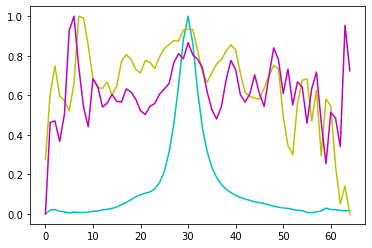

In [11]:
fig, ax = plt.subplots()
ax.plot(minmax_scale(ave_cyan), c='c')
ax.plot(minmax_scale(ave_yellow), c='y')
ax.plot(minmax_scale(ave_magenta), c='m')

### Save as `outputs/.csv` 

Save the averages as 1 `csv` file where each column is a color. And save each individual colors as separate `csv` files.

In [12]:
df_example_average = pd.DataFrame({'cyan': minmax_scale(ave_cyan),
                                   'yellow': minmax_scale(ave_yellow),
                                   'magenta': minmax_scale(ave_magenta)})
# exports:
df_example_average.to_csv(output_dir+'/averages.csv', index = False)            # export averages for all 3 channels
cyan_aligned.to_csv(output_dir+'/cyan_unnormalized.csv', index=False)           # cyan aligned and unnormalized
yellow_aligned.to_csv(output_dir+'/yellow_unnormalized.csv', index=False)       # yellow aligned and unnormalized
magenta_aligned.to_csv(output_dir+'/magenta_unnormalized.csv', index=False)     # magenta aligned and unnormalized
cyan_normalized.to_csv(output_dir+'/cyan_normalized.csv', index=False)          # cyan aligned and normalized
yellow_normalized.to_csv(output_dir+'/yellow_normalized.csv', index=False)      # yellow aligned and normalized
magenta_normalized.to_csv(output_dir+'/magenta_normalized.csv', index=False)    # magenta aligned and normalized

## Heatmaps according to Morgan's idea:

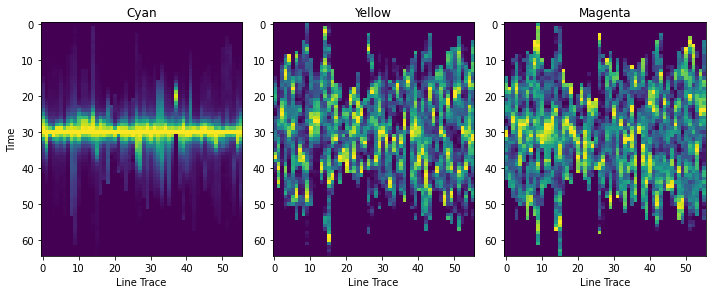

In [33]:
fig = plt.figure(figsize=(10,8)).subplots(1,3, sharey=True)

# cyan
plt.subplot(1,3,1)
plt.imshow(cyan_normalized.values)
plt.title('Cyan')
plt.xlabel('Line Trace')
plt.ylabel('Time')

# yellow
plt.subplot(1,3,2)
plt.imshow(yellow_normalized.values)
plt.title('Yellow')
plt.xlabel('Line Trace')

# magenta
plt.subplot(1,3,3)
plt.imshow(magenta_normalized.values)
plt.title('Magenta')
plt.xlabel('Line Trace')

plt.tight_layout()
#fig.colorbar(im, ax=axes.ravel().tolist())
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)